## Linear unmixing code for CT2B
## Input images
- Signal images
- `T1b`: blue channel (DAPI) obtained at time point 1 (0 min in this study);
- `T1g`: green channel (AF488) obtained at time point 1 (0 min in this study);
- `T1y`: yellow channel (CY3) obtained at time point 1 (0 min in this study);
- `T1r`: red channel (CY5) obtained at time point 1 (0 min in this study);
- `T2b`: blue channel (DAPI) obtained at time point 2 (15 min in this study);
- `T2g`: green channel (AF488) obtained at time point 2 (15 min in this study);
- `T2y`: yellow channel (CY3) obtained at time point 2 (15 min in this study);
- `T2r`: red channel (CY5) obtained at time point 2 (15 min in this study);
- `T3b`: blue channel (DAPI) obtained at time point 3 (30 min in this study);
- `T3g`: green channel (AF488) obtained at time point 3 (30 min in this study);
- `T3y`: yellow channel (CY3) obtained at time point 3 (30 min in this study);
- `T3r`: red channel (CY5) obtained at time point 3 (30 min in this study);
- Background images
- `Tbb`：background images of T1b, T2b, and T3b;
- `Tbg`：background images of T1g, T2g, and T3g;
- `Tby`：background images of T1y, T2y, and T3y;
- `Tbr`：background images of T1r, T2r, and T3r;
- The background images are obtained from the same region of the same tissue just before fluorescent antibody incubation. These images are captured under identical microscopic parameters.

## 1. Image alignment
- In the `Image aligment` step, the DAPI channels are first aligned to the spatial reference image `DAPI0`. The other channels are then transformed using the same transformation parameters applied to the DAPI channel.
- The background images are also aligned to the spatial reference image.

In [1]:
import cv2
import numpy as np

def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}. Check the file path and integrity.")
    else:
        # Optionally resize the image to reduce memory usage
        print(f"Successfully loaded image from {image_path} with shape {image.shape}")
    return image

def align_images(base_image, target_image):
    if base_image is None or target_image is None:
        print("Error: One of the images is not loaded.")
        return None, None

    try:
        # Convert images to grayscale
        base_gray = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
        target_gray = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
        
        # Initialize SIFT detector
        sift = cv2.SIFT_create()

        # Find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(base_gray, None)
        kp2, des2 = sift.detectAndCompute(target_gray, None)

        # Check if descriptors are found
        if des1 is None or des2 is None:
            print("Error: Descriptors not found in one of the images.")
            return None, None

        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        # Initialize FLANN matcher
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Match descriptors using KNN
        matches = flann.knnMatch(des1, des2, k=2)

        # Store good matches as per Lowe's ratio test.
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        if len(good_matches) > 4:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Calculate Homography
            H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            # Warp target image to align with the base image
            aligned_image = cv2.warpPerspective(target_image, H, (base_image.shape[1], base_image.shape[0]))
            return aligned_image, H
        else:
            print("Error: Not enough matches found.")
            return None, None
    except cv2.error as e:
        print(f"OpenCV error: {e}")
        return None, None

# Load images
DAPI0 = load_image(r'D://Linear unmixing//1_alignment//DAPI0.tif')
DAPI = load_image(r'D://Linear unmixing//1_alignment//DAPI.tif')

# Align DAPI to DAPI0 if loaded successfully
if DAPI0 is not None and DAPI is not None:
    aligned_DAPI, H2 = align_images(DAPI0, DAPI)
    if aligned_DAPI is None:
        print("Failed to align DAPI. Exiting.")
        exit()

# Load channels for DAPI (CY5, CY3, AF488)
CY5 = load_image(r'D://Linear unmixing//1_alignment//CY5.tif')
CY3 = load_image(r'D://Linear unmixing//1_alignment//CY3.tif')
AF488 = load_image(r'D://Linear unmixing//1_alignment//AF488.tif')

if CY5 is not None and CY3 is not None and AF488 is not None:
    # Apply the same transformation to channels
    aligned_CY5 = cv2.warpPerspective(CY5, H2, (DAPI0.shape[1], DAPI0.shape[0]))
    aligned_CY3 = cv2.warpPerspective(CY3, H2, (DAPI0.shape[1], DAPI0.shape[0]))
    aligned_AF488 = cv2.warpPerspective(AF488, H2, (DAPI0.shape[1], DAPI0.shape[0]))
    print("Aligned channels for DAPI successfully.")
else:
    print("Failed to load one or more channels for DAPI. Exiting.")

# Save aligned images
if aligned_DAPI is not None:
    cv2.imwrite('D://Linear unmixing//1_alignment//aligned_DAPI.tif', aligned_DAPI)
    print("Aligned DAPI saved as 'aligned_DAPI.tif'.")

if aligned_CY5 is not None:
    cv2.imwrite('D://Linear unmixing//1_alignment//aligned_CY5.tif', aligned_CY5)
    print("Aligned CY5 saved as 'aligned_CY5.tif'.")

if aligned_CY3 is not None:
    cv2.imwrite('D://Linear unmixing//1_alignment//aligned_CY3.tif', aligned_CY3)
    print("Aligned CY3 saved as 'aligned_CY3.tif'.")

if aligned_AF488 is not None:
    cv2.imwrite('D://Linear unmixing//1_alignment//aligned_AF488.tif', aligned_AF488)
    print("Aligned AF488 saved as 'aligned_AF488.tif'.")

Successfully loaded image from D://Linear unmixing//1_alignment//DAPI0.tif with shape (2208, 2752, 3)
Successfully loaded image from D://Linear unmixing//1_alignment//DAPI.tif with shape (2208, 2752, 3)
Successfully loaded image from D://Linear unmixing//1_alignment//CY5.tif with shape (2208, 2752, 3)
Successfully loaded image from D://Linear unmixing//1_alignment//CY3.tif with shape (2208, 2752, 3)
Successfully loaded image from D://Linear unmixing//1_alignment//AF488.tif with shape (2208, 2752, 3)
Aligned channels for DAPI successfully.
Aligned DAPI saved as 'aligned_DAPI.tif'.
Aligned CY5 saved as 'aligned_CY5.tif'.
Aligned CY3 saved as 'aligned_CY3.tif'.
Aligned AF488 saved as 'aligned_AF488.tif'.


## 2. Background removal
- This section aims to remove background from the signal images, so that it will not interference subsequent linear unmixing.
- The background images are obtained from the same region of the same tissue just before fluorescent antibody incubation. These images are captured under identical microscopic parameters.

In [13]:
import cv2
import numpy as np

# Import images
Main = cv2.imread('D://Linear unmixing//2_removal//Main.tif', cv2.IMREAD_GRAYSCALE)
Background = cv2.imread('D://Linear unmixing//2_removal//Background.tif', cv2.IMREAD_GRAYSCALE)

# Get the size of each image
height, width = Main.shape

# Create an empty matrix to store the new gray value
new_gray_values = np.zeros((height, width), dtype=np.uint16)

# Traverse each pixel coordinate
for i in range(height):
    for j in range(width):
        # Calculate the new gray value according to the pre-set color barcode (the following is just an example for SV2)
        if Main[i, j] > Background[i, j]:
            new_gray_values[i, j] = Main[i, j] - Background[i, j]
        else:
            new_gray_values[i, j] = 0
# Convert the new grayscale value matrix to an image
cv2.imwrite('D://Linear unmixing//2_removal//filtered_image.tif', new_gray_values)

True

## 3. Crop aligned images to the same size
- This step is accomplished with the help of Fiji using the following Java code：
- Fiji software can be downloaded from the [official Fiji software website](https://imagej.net/software/fiji/downloads).

In [ ]:
# To generate a customized code: Open Fiji → Plugins → Macro → Record
# To run the code: Open Fiji → Process → Batch → Macro
# Input folder: D://Linear unmixing//3_Fiji_input
# Output folder: D://Linear unmixing//3_Fiji_output
run("8-bit");
//setTool("rectangle");
makeRectangle(129, 315, 1024, 1024);
# To choose an appropriate size to crop: Open Fiji → open one of the image → choose Rectangle → the size will be shown in the software: x=4.18 (129), y=5.11 (315), w=0.50 (1024), h=0.46 (1024);
# The cropped dimensions will be: 1024px* 1024px, as illustrated by the values w=0.50 (1024), h=0.46 (1024);
run("Crop");

## 4. Extra color-changing information from raw images to one-dimensional arrays
For each pixel in the CT2B image, the color-changing information over different time points is stored in a one-dimensional array_m and displayed as follows: 
```
array_m = np.array([T1g, T1y, T1r, T2g, T2y, T2r, T3g, T3y, T3r])
```

- `T1g`: green channel (AF488) image obtained at time point 1 (0 min in this study)
- `T1y`: yellow channel (CY3) image obtained at time point 1 (0 min in this study)
- `T1r`: red channel (CY5) image obtained at time point 1 (0 min in this study)
- `T2g`: green channel (AF488) image obtained at time point 2 (15 min in this study)
- `T2y`: yellow channel (CY3) image obtained at time point 2 (15 min in this study)
- `T2r`: red channel (CY5) image obtained at time point 2 (15 min in this study)
- `T3g`: green channel (AF488) image obtained at time point 3 (30 min in this study)
- `T3y`: yellow channel (CY3) image obtained at time point 3 (30 min in this study)
- `T3r`: red channel (CY5) image obtained at time point 3 (30 min in this study)

The color-changing information for each pixel is then stored in a worksheet, where the cell coordinates correspond to the pixel coordinates in the image.

In [14]:
import os
import pandas as pd
from PIL import Image
from openpyxl import Workbook

# image file path
image_files = [
    'D://Linear unmixing//4_extra//T1g.tif',
    'D://Linear unmixing//4_extra//T1y.tif',
    'D://Linear unmixing//4_extra//T1r.tif',
    'D://Linear unmixing//4_extra//T2g.tif',
    'D://Linear unmixing//4_extra//T2y.tif',
    'D://Linear unmixing//4_extra//T2r.tif',
    'D://Linear unmixing//4_extra//T3g.tif',
    'D://Linear unmixing//4_extra//T3y.tif',
    'D://Linear unmixing//4_extra//T3r.tif'
]

# create a new workbook
wb = Workbook()
ws = wb.active
ws.title = "Gray Values"

# create a dictionary to store the grayscale values of coordinates
gray_value_dict = {}

# iterate through each image file
for image_file in image_files:
    with Image.open(image_file) as img:
        # ensure it is in grayscale mode
        if img.mode != 'L':
            raise ValueError(f"{image_file} not a grayscale image")
        
        # get image size
        width, height = img.size
        
        # extract the grayscale value of each pixel
        for y in range(height):
            for x in range(width):
                value = img.getpixel((x, y))
                
                # use the coordinates (x, y) as the key in the dictionary
                if (x, y) not in gray_value_dict:
                    gray_value_dict[(x, y)] = []
                gray_value_dict[(x, y)].append(value)

# write the grayscale values to the worksheet
for (x, y), values in gray_value_dict.items():
    # Combine grayscale values with the same coordinates into a one-dimensional array
    combined_values = ', '.join(map(str, values))
    ws.cell(row=y + 1, column=x + 1, value=combined_values)

# write the grayscale values to the worksheet
output_file = 'D://Linear unmixing//4_extra//raw_data.xlsx'
wb.save(output_file)

print(f"grayscale values have been exported to {output_file}")

grayscale values have been exported to D://Linear unmixing//4_extra//raw_data.xlsx


## 5. Establish 'reference spectrum' for each color barcode
- For each color barcode, the corresponding protein is stained and undergoes the unique color change to establish a 'referece spectrum' (array_1 to array_27).
- The 'reference spectrum' from different positive pixels are extracted, averaged and normalized. 

There are two instances of `coefficient of variation, CV (%)` used in Section 5, each representing different meanings:
- In `Section 5.1`, CV reflects the degree of dispersion of the signal from different pixels. A higher CV indicates a larger dynamic range of the protein. It does not influence the subsequent linear unmixing process.
- In `Section 5.4`, CV refers to the variation in the ratio of the reference spectrum. A lower CV indicates greater consistency of the color barcode, which is more beneficial for the subsequent linear unmixing process.

### 5.1 Establish 'reference spectrum' from postive images
- The signal-positive region is cropped for signal extraction to generate nuique 'referece spectrum'.

In [61]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_HALF_UP

# Read the Excel file, ensuring that the first row is used as the data header.
file_path = 'D://Linear unmixing//5_reference spectrum//raw_data.xlsx'  # Data is from "singnal extraction section"
df = pd.read_excel(file_path, header=None)  

# Store all values for each coordinate
all_values = [[] for _ in range(len(df.iloc[0].dropna().iloc[0].split(',')))]

# Iterate through each cell.
for index, row in df.iterrows():
    for value in row:
        if pd.notna(value):
            numbers = list(map(float, value.split(',')))
            for i, num in enumerate(numbers):
                all_values[i].append(num)

# Calculate mean, standard deviation, and coefficient of variation
mean_values = []
cv_values = []

for values in all_values:
    if values:
        mean = np.mean(values)
        std = np.std(values, ddof=1)  # ddof=1 for sample standard deviation
        cv = (std / mean) * 100 if mean != 0 else 0
        mean_values.append(Decimal(str(mean)))
        cv_values.append(round(cv, 3))
    else:
        mean_values.append(Decimal('0'))
        cv_values.append(0)

# Find the maximum value in the mean_values
max_mean_value = max(mean_values)

# Normalize the mean values by dividing by the maximum mean value and round to 3 decimal places
normalized_mean_values = [
    (value / max_mean_value).quantize(Decimal('0.001'), rounding=ROUND_HALF_UP)
    for value in mean_values
]

# Convert Decimal objects to floats for easier printing
normalized_mean_values = [float(value) for value in normalized_mean_values]

# Output the normalized mean values and coefficient of variation.
print("The coefficient of variation (%) for each position is:", cv_values)
print("The 'reference spectrum' is:", mean_values)
print("The normalized 'reference spectrum' is:", normalized_mean_values)

The coefficient of variation (%) for each position is: [nan, nan, nan, nan, nan, nan, nan, nan, nan]
The 'reference spectrum' is: [Decimal('0.23'), Decimal('0.44'), Decimal('1.09'), Decimal('0.33'), Decimal('0.21'), Decimal('2.11'), Decimal('0.18'), Decimal('0.38'), Decimal('1.73')]
The normalized 'reference spectrum' is: [0.109, 0.209, 0.517, 0.156, 0.1, 1.0, 0.085, 0.18, 0.82]


C:\Users\xujiasu\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\xujiasu\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### 5.2 Establish 'reference spectrum' from postive pixels
- If you cannot guarantee that all the pixels in the cropped images contain positive signals, the code below offers a convenient method for users to extract those positive signals.

In [28]:
import pandas as pd

# Read the Excel file
file_path = 'D://Linear unmixing//5_reference spectrum//raw_data.xlsx'
df = pd.read_excel(file_path, header=None)

# Create an empty list to store rows that meet the conditions
filtered_data = []

# Iterate through each cell and check if it meets the conditions
for index, row in df.iterrows():
    new_row = []  # Used to store the new data for the current row
    for col in df.columns:
        # Convert the string in the cell into a list of numbers
        values = row[col].split(',')
        # Convert the strings to floating-point numbers
        try:
            values = [float(value) for value in values]
        except ValueError:
            new_row.append(None)
            continue
        
        # Check the conditions for the second, fourth, and ninth elements
        if (len(values) > 1 and values[1] > 20) and \
           (len(values) > 5 and values[5] > 20) and \
           (len(values) > 6 and values[6] > 8):
            # Convert the list back to a comma-separated string
            new_row.append(','.join(map(str, values)))
        else:
            new_row.append(None)

    # Add the new row to the filtered_data list
    filtered_data.append(new_row)

# Convert the filtered results to a DataFrame
filtered_df = pd.DataFrame(filtered_data, columns=df.columns)

# Save the filtered results to a new Excel file without including the row index
output_file_path = 'D://Linear unmixing//5_reference spectrum//pos_raw_data.xlsx'
filtered_df.to_excel(output_file_path, index=False, header=False)

print("Filtered data has been saved to:", output_file_path)

Filtered data has been saved to: D://Linear unmixing//5_reference spectrum//pos_raw_data.xlsx


### 5.3 Evaluate the consistency of reference spectrum of interested pixels

In [31]:
import numpy as np

# Input three one-dimensional arrays
seq1 = np.array([0.0, 27.0, 0.0, 2.0, 0.0, 21.0, 10.0, 0.0, 0.0])
seq2 = np.array([0.0, 32.0, 0.0, 2.0, 1.0, 32.0, 10.0, 0.0, 0.0])
seq3 = np.array([0.0, 25.0, 0.0, 1.0, 1.0, 26.0, 15.0, 0.0, 0.0])

# Form a matrix by combining the three sequences
matrix = np.vstack((seq1, seq2, seq3))

# Calculate the correlation coefficient matrix
corr_matrix = np.corrcoef(matrix)

# Print results
print("Correlation coefficient matrix:")
print(corr_matrix)

# Interpret the result
pairs = [("seq1", "seq2"), ("seq1", "seq3"), ("seq2", "seq3")]
for i, (name1, name2) in enumerate(pairs):
    # Obtain the index of the corresponding sequence in the matrix
    index1 = int(name1[-1]) - 1
    index2 = int(name2[-1]) - 1
    correlation = corr_matrix[index1][index2]
    print(f"\n{name1} vs {name2} : {correlation:.4f}")
    if correlation > 0.8:
        print("Strong correlation")
    elif correlation > 0.5:
        print("Moderate correlation")
    elif correlation > 0.3:
        print("Weak correlation")
    elif correlation > -0.3:
        print("Almost no linear correlation")
    else:
        print("Negative correlation")

Correlation coefficient matrix:
[[1.         0.98589834 0.97680566]
 [0.98589834 1.         0.97739854]
 [0.97680566 0.97739854 1.        ]]

seq1 vs seq2 : 0.9859
Strong correlation

seq1 vs seq3 : 0.9768
Strong correlation

seq2 vs seq3 : 0.9774
Strong correlation


### 5.4 Evaluat the overall consistency of the reference spectrum

Correlation Matrix:
[[1.         0.957267   0.97281401 ... 0.93442069 0.97954277 0.98831944]
 [0.957267   1.         0.98774857 ... 0.9962118  0.99472523 0.91055701]
 [0.97281401 0.98774857 1.         ... 0.97942099 0.98883665 0.93048746]
 ...
 [0.93442069 0.9962118  0.97942099 ... 1.         0.98621928 0.87573881]
 [0.97954277 0.99472523 0.98883665 ... 0.98621928 1.         0.94276383]
 [0.98831944 0.91055701 0.93048746 ... 0.87573881 0.94276383 1.        ]]


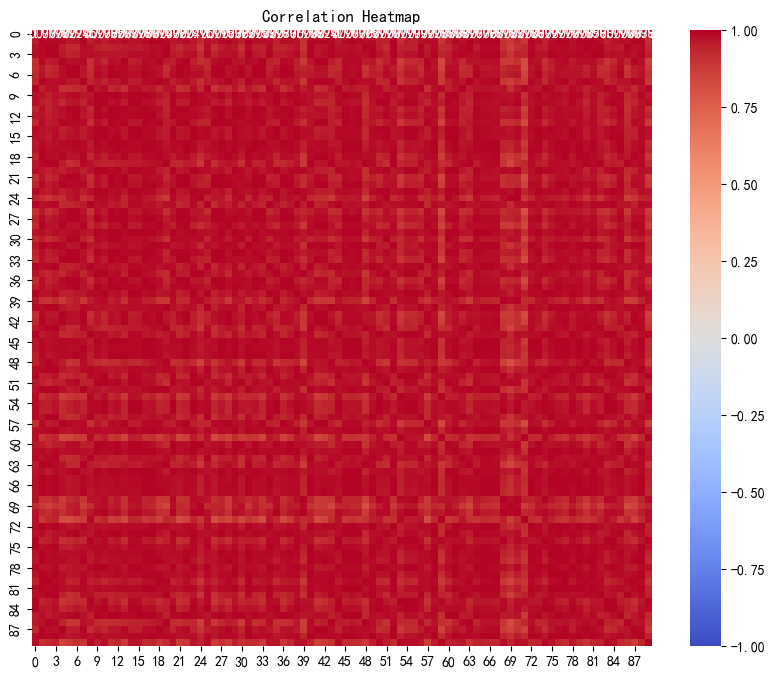

Mean of correlation coefficients: 0.9674
Coefficient of variation of correlation coefficients: 0.0305


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Read data from an Excel file and process the strings in the cells
def read_data_from_excel(file_path):
    try:
        df = pd.read_excel(file_path)
        data = []
        for col in df.columns:
            for value in df[col]:
                if isinstance(value, str):
                    try:
                        # Convert the string to a numeric array
                        seq = np.array([float(x) for x in value.split(',')])
                        data.append(seq)
                    except ValueError:
                        print(f"Error: Unable to convert '{value}' to a numeric array.")
        return np.array(data)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except Exception as e:
        print(f"Error: An unknown error occurred while reading the file: {e}")
        return None


# Calculate the correlation matrix
def calculate_correlation_matrix(data):
    return np.corrcoef(data)


# Plot the correlation heatmap
def plot_correlation_heatmap(corr_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()


# Calculate the mean and coefficient of variation of the correlation coefficients
def calculate_statistics(corr_matrix):
    # Get the lower triangular part of the correlation matrix (excluding the diagonal)
    lower_triangle = corr_matrix[np.tril_indices(corr_matrix.shape[0], k=-1)]
    mean_corr = np.mean(lower_triangle)
    std_corr = np.std(lower_triangle)
    cv_corr = std_corr / mean_corr if mean_corr != 0 else 0
    return mean_corr, cv_corr


if __name__ == "__main__":
    file_path = 'D://Linear unmixing//5_reference spectrum//raw_data2.xlsx'  # Please replace with the path to your Excel file
    data = read_data_from_excel(file_path)
    if data is not None:
        corr_matrix = calculate_correlation_matrix(data)
        print("Correlation Matrix:")
        print(corr_matrix)

        plot_correlation_heatmap(corr_matrix)

        mean_corr, cv_corr = calculate_statistics(corr_matrix)
        print(f"Mean of correlation coefficients: {mean_corr:.4f}")
        print(f"Coefficient of variation of correlation coefficients: {cv_corr:.4f}")

### 5.5 All 27 'reference spectrum' established in this work
- Barcode 1# AF488 → Cy3 → Cy5 `array_1 = np.array([1.000, 0.150, 0.195, 0.106, 0.947, 0.071, 0.124, 0.186, 1.000])`
- Barcode 2# AF488 → Cy5 → Cy3 `array_2 = np.array([0.887, 0.128, 0.149, 0.202, 0.135, 0.837, 0.113, 1.000, 0.234])`
- Barcode 3# Cy3 → Cy5 → AF488 `array_3 = np.array([0.083, 0.750, 0.205, 0.015, 0.174, 0.727, 1.000, 0.167, 0.159])`
- Barcode 4# Cy3 → AF488 → Cy5 `array_4 = np.array([0.090, 0.967, 0.139, 1.000, 0.189, 0.090, 0.025, 0.041, 0.951])`
- Barcode 5# Cy5 → Cy3 → AF488 `array_5 = np.array([0.085, 0.104, 0.776, 0.214, 1.000, 0.164, 0.937, 0.060, 0.209])`
- Barcode 6# Cy5 → AF488 → Cy3 `array_6 = np.array([0.239, 0.152, 0.848, 0.928, 0.246, 0.152, 0.268, 1.000, 0.159])`
- Barcode 7# AF488 → Cy3 → AF488 `array_7 = np.array([0.715, 0.173, 0.073, 0.017, 1.000, 0.151, 0.972, 0.184, 0.145])`
- Barcode 8# AF488 → Cy5 → AF488 `array_8 = np.array([0.944, 0.278, 0.111, 0.270, 0.262, 1.000, 0.746, 0.214, 0.032])`
- Barcode 9# Cy3 → AF488 → Cy3 `array_9 = np.array([0.151, 0.889, 0.128, 0.890, 0.123, 0.100, 0.100, 1.000, 0.068])`
- Barcode 10# Cy3 → Cy5 → Cy3 `array_10 = np.array([0.198, 0.945, 0.163, 0.110, 0.134, 0.878, 0.076, 1.000, 0.134])`
- Barcode 11# Cy5 → AF488 → Cy5 `array_11 = np.array([0.155, 0.113, 0.934, 0.969, 0.129, 0.268, 0.191, 0.232, 1.000])`
- Barcode 12# Cy5 → Cy3 → Cy5 `array_12 = np.array([0.149, 0.155, 0.724, 0.188, 1.000, 0.182, 0.122, 0.227, 0.972])`
- Barcode 13# AF488 → Cy3 → Cy3 `array_13 = np.array([0.924, 0.124, 0.200, 0.124, 1.000, 0.178, 0.178, 0.968, 0.135])`
- Barcode 14# AF488 → Cy5 → Cy5 `array_14 = np.array([1.000, 0.071, 0.197, 0.039, 0.071, 0.961, 0.087, 0.181, 0.969])`
- Barcode 15# Cy3 → AF488 → AF488 `array_15 = np.array([0.053, 0.957, 0.043, 1.000, 0.135, 0.053, 0.923, 0.053, 0.135])`
- Barcode 16# Cy3 → Cy5 → Cy5 `array_16 = np.array([0.079, 0.857, 0.146, 0.140, 0.067, 1.000, 0.163, 0.152, 0.911])`
- Barcode 17# Cy5 → AF488 → AF488 `array_17 = np.array([0.066, 0.079, 1.000, 0.966, 0.072, 0.100, 0.962, 0.076, 0.024])`
- Barcode 18# Cy5 → Cy3 → Cy3 `array_18 = np.array([0.164, 0.130, 0.718, 0.051, 0.706, 0.085, 0.040, 1.000, 0.124])`
- Barcode 19# AF488 → AF488 → Cy3 `array_19 = np.array([0.938, 0.256, 0.194, 0.884, 0.016, 0.085, 0.178, 1.000, 0.256])`
- Barcode 20# AF488 → AF488 → Cy5 `array_20 = np.array([0.712, 0.130, 0.062, 0.887, 0.147, 0.209, 0.186, 0.119, 1.000])`
- Barcode 21# Cy3 → Cy3 → AF488 `array_21 = np.array([0.059, 1.000, 0.223, 0.181, 0.777, 0.303, 0.846, 0.197, 0.181])`
- Barcode 22# Cy3 → Cy3 → Cy5 `array_22 = np.array([0.015, 0.976, 0.054, 0.015, 1.000, 0.039, 0.167, 0.108, 0.872])`
- Barcode 23# Cy5 → Cy5 → AF488 `array_23 = np.array([0.129, 0.193, 1.000, 0.150, 0.090, 0.897, 0.922, 0.090, 0.039])`
- Barcode 24# Cy5 → Cy5 → Cy3 `array_24 = np.array([0.082, 0.088, 0.959, 0.211, 0.102, 0.769, 0.150, 1.000, 0.170])`
- Barcode 25# AF488 → AF488 → AF488 `array_25 = np.array([0.891, 0.006, 0.032, 0.727, 0.136, 0.097, 1.000, 0.078, 0.227])`
- Barcode 26# Cy3 → Cy3 → Cy3 `array_26 = np.array([0.082, 0.915, 0.146, 0.105, 0.708, 0.135, 0.123, 1.000, 0.246])`
- Barcode 27# Cy5 → Cy5 → Cy5 `array_27 = np.array([0.109, 0.209, 0.917, 0.156, 0.100, 1.000, 0.085, 0.180, 0.820])`

## 6. Linear unmixing
The fundamental concept of linear unmixing is based on the following formula:

 `array_m = C1*array_1 + C2*array_2 + …… + C27*array_27`

- `array_m`：Color-changing information of each pixel.
- `array_1` ~ `array_27`: Reference spectrum generated in section 5.
- `contribution factor (C)`: Contribution of array_x in making up array_m, which also corresponds to the relative fluorescence intensity of the recontrasted image.
- The match score, represented by the Mean Squared Error (MSE), can be fine-tuned to achieve optimal results. In our study, a threshold of MSE < 20 is applied, and values exceeding this threshold are deemed unreliable and excluded from analysis (i.e., set to zero).

### 6.1 Code driven by pure mathematics

In [5]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import mean_squared_error
from scipy.optimize import nnls
import openpyxl

# Read the Excel file (raw_data.xlsx)
input_df = pd.read_excel('D://Linear unmixing//6_linear unmixing//raw_data.xlsx', header=None)

# Reference spectrum (generated in section 5)
arrays = [
  np.array([1.000, 0.150, 0.195, 0.106, 0.947, 0.071, 0.124, 0.186, 1.000]), #array_1
  np.array([0.887, 0.128, 0.149, 0.202, 0.135, 0.837, 0.113, 1.000, 0.234]), #array_2
  np.array([0.083, 0.750, 0.205, 0.015, 0.174, 0.727, 1.000, 0.167, 0.159]), #array_3
  np.array([0.090, 0.967, 0.139, 1.000, 0.189, 0.090, 0.025, 0.041, 0.951]), #array_4
  np.array([0.085, 0.104, 0.776, 0.214, 1.000, 0.164, 0.937, 0.060, 0.209]), #array_5
  np.array([0.239, 0.152, 0.848, 0.928, 0.246, 0.152, 0.268, 1.000, 0.159]), #array_6
  np.array([0.715, 0.173, 0.073, 0.017, 1.000, 0.151, 0.972, 0.184, 0.145]), #array_7
  np.array([0.944, 0.278, 0.111, 0.270, 0.262, 1.000, 0.746, 0.214, 0.032]), #array_8
  np.array([0.151, 0.889, 0.128, 0.890, 0.123, 0.100, 0.100, 1.000, 0.068]), #array_9
  np.array([0.198, 0.945, 0.163, 0.110, 0.134, 0.878, 0.076, 1.000, 0.134]), #array_10
  np.array([0.155, 0.113, 0.934, 0.969, 0.129, 0.268, 0.191, 0.232, 1.000]), #array_11
  np.array([0.149, 0.155, 0.724, 0.188, 1.000, 0.182, 0.122, 0.227, 0.972]), #array_12
  np.array([0.924, 0.124, 0.200, 0.124, 1.000, 0.178, 0.178, 0.968, 0.135]), #array_13
  np.array([1.000, 0.071, 0.197, 0.039, 0.071, 0.961, 0.087, 0.181, 0.969]), #array_14
  np.array([0.053, 0.957, 0.043, 1.000, 0.135, 0.053, 0.923, 0.053, 0.135]), #array_15
  np.array([0.079, 0.857, 0.146, 0.140, 0.067, 1.000, 0.163, 0.152, 0.911]), #array_16
  np.array([0.066, 0.079, 1.000, 0.966, 0.072, 0.100, 0.962, 0.076, 0.024]), #array_17
  np.array([0.164, 0.130, 0.718, 0.051, 0.706, 0.085, 0.040, 1.000, 0.124]), #array_18
  np.array([0.938, 0.256, 0.194, 0.884, 0.016, 0.085, 0.178, 1.000, 0.256]), #array_19
  np.array([0.712, 0.130, 0.062, 0.887, 0.147, 0.209, 0.186, 0.119, 1.000]), #array_20
  np.array([0.059, 1.000, 0.223, 0.181, 0.777, 0.303, 0.846, 0.197, 0.181]), #array_21
  np.array([0.015, 0.976, 0.054, 0.015, 1.000, 0.039, 0.167, 0.108, 0.872]), #array_22
  np.array([0.129, 0.193, 1.000, 0.150, 0.090, 0.897, 0.922, 0.090, 0.039]), #array_23
  np.array([0.082, 0.088, 0.959, 0.211, 0.102, 0.769, 0.150, 1.000, 0.170]), #array_24
  np.array([0.891, 0.006, 0.032, 0.727, 0.136, 0.097, 1.000, 0.078, 0.227]), #array_25
  np.array([0.082, 0.915, 0.146, 0.105, 0.708, 0.135, 0.123, 1.000, 0.246]), #array_26
  np.array([0.109, 0.209, 0.917, 0.156, 0.100, 1.000, 0.085, 0.180, 0.820]), #array_27
]

def find_combinations(array_m, arrays, max_arrays=5):
    best_combination = None
    best_constants = None
    best_score = float('inf')

    for n in range(1, max_arrays + 1):
        for combo in combinations(enumerate(arrays), n):
            indices, selected_arrays = zip(*combo)
            
            A = np.array(selected_arrays).T
            b = array_m
            try:
                constants, _ = nnls(A, b)
                predicted = np.dot(A, constants)
                score = mean_squared_error(array_m, predicted)
                
                if score < best_score:
                    best_score = score
                    best_combination = indices
                    best_constants = constants
            except ValueError:
                continue

    return best_combination, best_constants, best_score

# Creat a new Excel file to store results
workbook = openpyxl.Workbook()

# Define the sheet with array and protein name
sheet_names = ['array1_CD3', 'array2_CD4', 'array3_CD8a', 'array4_CD20', 'array5_EGFR', 'array6_PR', 'array7_CD45RO', 'array8_CD68', 'array9_Foxp3', 'array10_PIP', 'array11_HER2', 'array12_CD31', 'array13_α-SMA', 'array14_CK5/6', 'array15_CK19', 'array16_CD56', 'array17_CD80', 'array18_CD163', 'array19_GZMB', 'array20_MPO', 'array21_PDPN', 'array22_CD19', 'array23_ER', 'array24_CD45RA', 'array25_Ki67', 'array26_p63', 'array27_AR', 'Match Score']

# Create an empty DataFrame for each sheet and fill it with 0.0
results = {name: pd.DataFrame(0.0, index=input_df.index, columns=input_df.columns, dtype=float) for name in sheet_names}

# Calculate the optimal combination for each cell
for row in range(input_df.shape[0]):
    for col in range(input_df.shape[1]):
        cell_value = input_df.iloc[row, col]
        if pd.notna(cell_value):  # Check if the cell is empty
            array_m = np.array([float(x) for x in str(cell_value).split(',')])  # Convert the cell value to an array
            if len(array_m) == len(arrays[0]):  # Ensure length matches
                combination, constants, score = find_combinations(array_m, arrays)
                
                if score <= 20:
                    for i, const in zip(combination, constants):
                        results[sheet_names[i]].iloc[row, col] = const
                
                results['Match Score'].iloc[row, col] = score
            else:
                print(f"Warning: Mismatch in array length at row {row+1}, column {col+1}")

# Write the results to Excel file
with pd.ExcelWriter('D://Linear unmixing//6_linear unmixing//contribution_factor.xlsx', engine='openpyxl') as writer:
    for sheet_name, df in results.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

print("Results have been written to output_results.xlsx")

Results have been saved to output_results.xlsx


### 6.2 Combining mathematics with biological prior knowledge

In [ ]:
%%time
import numpy as np
from itertools import combinations
from sklearn.metrics import mean_squared_error
from scipy.optimize import nnls
from joblib import Parallel, delayed

# Array from one coordinate
array_m = np.array([0.082, 0.515, 0.146, 0.105, 0.708, 0.135, 0.123, 1.0, 0.246])

# Reference spectrum 
arrays = [
  np.array([1.000, 0.150, 0.195, 0.106, 0.947, 0.071, 0.124, 0.186, 1.000]), #array_1
  np.array([0.887, 0.128, 0.149, 0.202, 0.135, 0.837, 0.113, 1.000, 0.234]), #array_2
  np.array([0.083, 0.750, 0.205, 0.015, 0.174, 0.727, 1.000, 0.167, 0.159]), #array_3
  np.array([0.090, 0.967, 0.139, 1.000, 0.189, 0.090, 0.025, 0.041, 0.951]), #array_4
  np.array([0.085, 0.104, 0.776, 0.214, 1.000, 0.164, 0.937, 0.060, 0.209]), #array_5
  np.array([0.239, 0.152, 0.848, 0.928, 0.246, 0.152, 0.268, 1.000, 0.159]), #array_6
  np.array([0.715, 0.173, 0.073, 0.017, 1.000, 0.151, 0.972, 0.184, 0.145]), #array_7
  np.array([0.944, 0.278, 0.111, 0.270, 0.262, 1.000, 0.746, 0.214, 0.032]), #array_8
  np.array([0.151, 0.889, 0.128, 0.890, 0.123, 0.100, 0.100, 1.000, 0.068]), #array_9
  np.array([0.198, 0.945, 0.163, 0.110, 0.134, 0.878, 0.076, 1.000, 0.134]), #array_10
  np.array([0.155, 0.113, 0.934, 0.969, 0.129, 0.268, 0.191, 0.232, 1.000]), #array_11
  np.array([0.149, 0.155, 0.724, 0.188, 1.000, 0.182, 0.122, 0.227, 0.972]), #array_12
  np.array([0.924, 0.124, 0.200, 0.124, 1.000, 0.178, 0.178, 0.968, 0.135]), #array_13
  np.array([1.000, 0.071, 0.197, 0.039, 0.071, 0.961, 0.087, 0.181, 0.969]), #array_14
  np.array([0.053, 0.957, 0.043, 1.000, 0.135, 0.053, 0.923, 0.053, 0.135]), #array_15
  np.array([0.079, 0.857, 0.146, 0.140, 0.067, 1.000, 0.163, 0.152, 0.911]), #array_16
  np.array([0.066, 0.079, 1.000, 0.966, 0.072, 0.100, 0.962, 0.076, 0.024]), #array_17
  np.array([0.164, 0.130, 0.718, 0.051, 0.706, 0.085, 0.040, 1.000, 0.124]), #array_18
  np.array([0.938, 0.256, 0.194, 0.884, 0.016, 0.085, 0.178, 1.000, 0.256]), #array_19
  np.array([0.712, 0.130, 0.062, 0.887, 0.147, 0.209, 0.186, 0.119, 1.000]), #array_20
  np.array([0.059, 1.000, 0.223, 0.181, 0.777, 0.303, 0.846, 0.197, 0.181]), #array_21
  np.array([0.015, 0.976, 0.054, 0.015, 1.000, 0.039, 0.167, 0.108, 0.872]), #array_22
  np.array([0.129, 0.193, 1.000, 0.150, 0.090, 0.897, 0.922, 0.090, 0.039]), #array_23
  np.array([0.082, 0.088, 0.959, 0.211, 0.102, 0.769, 0.150, 1.000, 0.170]), #array_24
  np.array([0.891, 0.006, 0.032, 0.727, 0.136, 0.097, 1.000, 0.078, 0.227]), #array_25
  np.array([0.082, 0.915, 0.146, 0.105, 0.708, 0.135, 0.123, 1.000, 0.246]), #array_26
  np.array([0.109, 0.209, 0.917, 0.156, 0.100, 1.000, 0.085, 0.180, 0.820]), #array_27
]

# Definition set
A = [0, 1, 2, 21, 3, 23, 6, 15, 7, 16, 17, 8, 18, 19]
B = [9, 10, 13, 14, 4, 22, 5, 26, 25]
C = [11, 12, 20]
D = [8, 4, 22, 5, 26, 24, 25]
E = [0, 1, 2, 21, 3, 23, 6, 15, 7, 16, 17, 8, 18, 19, 9, 10, 13, 14]

# Combinations that are not allowed to occur simultaneously
invalid_pairs = [(23, 6), (1, 2)]

# Preferred combinations
preferred_combinations = [
    (0, 1, 23),
    (0, 1, 6),
    (0, 2, 23),
    (0, 2, 6),
    (0, 2, 18, 23),
    (0, 2, 18, 6),
    (7, 16),
    (7, 17),
] + [
    (i,) for i in [4, 22, 5, 26, 24, 25]
] + [
    comb for n in range(2, 6) for comb in combinations([4, 22, 5, 26, 24, 25], n)
] + [
    (i,) for i in [9, 10, 11, 13, 14]
] + [
    comb for n in range(2, 5) for comb in combinations([9, 10, 11, 13, 14], n)
] + [
    (8, 24),
    (21, 3),
    (12, 13),
    (15,),
    (19,),
    (20,),
    (25,)
]

def is_valid_combination(combination):
    indices = set([idx for idx, _ in combination])
    # Check if they belong to the same set
    if not any(all(i in s for i in indices) for s in [A, B, C, D, E]):
        return False
    # Check for prohibited combinations
    for pair in invalid_pairs:
        if all(p in indices for p in pair):
            return False
    return True

def calculate_score(combo):
    indices, selected_arrays = zip(*combo)
    A = np.array(selected_arrays).T
    b = array_m
    try:
        constants, _ = nnls(A, b)
        predicted = np.dot(A, constants)
        score = mean_squared_error(array_m, predicted)
        return indices, constants, score
    except ValueError:
        return None

def find_combinations(array_m, arrays, max_arrays=5):
    best_combinations = []
    best_score = float('inf')

    # Preferred combinations
    for pref_comb in preferred_combinations:
        if len(pref_comb) <= max_arrays:
            combo = tuple((idx, arrays[idx]) for idx in pref_comb)
            if is_valid_combination(combo):
                result = calculate_score(combo)
                if result:
                    indices, constants, score = result
                    if score < best_score:
                        best_score = score
                        best_combinations = [(indices, constants, score)]
                    elif score == best_score:
                        best_combinations.append((indices, constants, score))

    # Other combinations
    all_combinations = []
    for n in range(1, max_arrays + 1):
        all_combinations.extend(combinations(enumerate(arrays), n))

    all_combinations = [c for c in all_combinations if is_valid_combination(c)]

    results = Parallel(n_jobs=-1)(delayed(calculate_score)(combo) for combo in all_combinations)
    results = [r for r in results if r is not None]

    for indices, constants, score in results:
        if score < best_score:
            best_score = score
            best_combinations = [(indices, constants, score)]
        elif score == best_score:
            best_combinations.append((indices, constants, score))

    return best_combinations

# Find the best combinations
best_combinations = find_combinations(array_m, arrays)

# Print the results
for indices, constants, score in best_combinations:
    print("best match:")
    for idx, const in zip(indices, constants):
        print(f"array_{idx+1} * {const:.4f}")
    print(f"match score (MSE): {score:.6f}")
    print()

# Verify the results
if best_combinations:
    indices, constants, _ = best_combinations[0]
    result = sum(arrays[idx] * const for idx, const in zip(indices, constants))
    print("verify the results:")
    print("raw array:", array_m)
    print("calculated result:", result)
    print("match or not:", np.allclose(array_m, result))

## 7. Image display
- To `show image`: The raw data containing the contribution factor was displayed as a grayscale image (.tif) using the following code.
- To assign the decoded image (grayscale) with `pseudo color`: Open zen 3.11 software → Dimensions → Channels.
- To `merge images` of different proteins: Open zen 3.11 software → Processing → Method → Add channes.
- zen 3.11 software can be downloaded from the [official Zeiss software website](https://www.zeiss.com/microscopy/zh/products/software/zeiss-zen.html).

In [63]:
import pandas as pd
import numpy as np
from PIL import Image
import os

# Read the Excel file
input_file = 'D://Linear unmixing//7_image display//contribution_factor.xlsx'  # Replace with your input file name
excel = pd.ExcelFile(input_file)

# Get all sheet names
sheet_names = excel.sheet_names

# Create output folder
output_folder = 'D://Linear unmixing//7_image display'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each sheet
for sheet_name in sheet_names:
    # Read sheet data, including the first row
    df = pd.read_excel(excel, sheet_name=sheet_name, header=None)
    
    # Convert DataFrame to numpy array
    image_array = df.values.astype(np.uint16)
    
    # Create image
    image = Image.fromarray(image_array, mode='L')
    
    # Save as TIFF format
    output_file = os.path.join(output_folder, f'{sheet_name}.tiff')
    image.save(output_file, format='TIFF')
    
    print(f"Saved image for sheet {sheet_name}")

print(f"All images have been saved in the '{output_folder}' folder")

Saved image for sheet CD45
Saved image for sheet 02_
Saved image for sheet 03_
Saved image for sheet 04_
Saved image for sheet 05_
Saved image for sheet 06_
Saved image for sheet 07_
Saved image for sheet 08_
Saved image for sheet 09_
Saved image for sheet 10_
Saved image for sheet 11_
Saved image for sheet 12_
Saved image for sheet 13_
Saved image for sheet 14_
Saved image for sheet 15_
Saved image for sheet 16_
Saved image for sheet 17_
Saved image for sheet 18_
Saved image for sheet 19_
Saved image for sheet 20_
Saved image for sheet 21_
Saved image for sheet 22_
Saved image for sheet 23_
Saved image for sheet 24_
Saved image for sheet 25_
Saved image for sheet 26_
Saved image for sheet 27_
Saved image for sheet Match Score
All images have been saved in the 'D://Linear unmixing//7_image display' folder
